# Computational graphs and backpropagation

In this chapter we will introduce the fundamental concepts that underpin all deep learning - computational graphs and backpropagation. To showcase these ideas we will create and train a neural network from scratch which will solve a *very simple* classification task.

If you want to follow along, you will need to execute the following imports:

In [1]:
from math import *

import torch
import torch.nn as nn

from torch.autograd import Function

## Computational graph

The basic concept you need to understand in order to grasp neural networks is that of a **computational graph**. Remember that a *graph* has nodes and edges. In a *computational graph* the *nodes represent functions*. These functions take input values and produce (compute) output values. The *edges carry* these *values* (which are either input values to the graph or results of preceding computations). Computational graphs allow for simple representations of complex functions.

Consider the function $f: \mathbb{R}^3 \rightarrow \mathbb{R}, f(x, y, z) = (x + y) \cdot z$. We will write $f = (x + y) \cdot z$ to simplify notation.

This function really consists of two functions. The first function calculates $x + y$. The second function multiplies the result of $x + y$ by $z$. Put simply, we first compute $g = x + y$ and then calculate $f = g \cdot z$.

This is how the visual representation of the computational graph representing $f$ would look like:

<img src="images/compgraph.png" alt="drawing" width="300"/>

> Do note that this is not the most common visualization of computational graphs. Nevertheless we will stick to it, since it drives home most of the important ideas quite nicely.

We can see that the graph has two nodes. The first node represents an addition function. It takes the values $x$ and $y$ and outputs the value $g$. The second node represents a multiplication function. It takes the values $g$ and $z$ and outputs the value $f$. Note that here one of the inputs to the multiplication node (namely $g$) is the output of a preceding node (namely the addition node).

By decomposing arbitrary functions into simple components we can create computational graphs that represent very complex functions. In fact **neural networks** are nothing more than just certain kinds of computational graphs, namely computational graphs which are *differentiable*. This means that every node function has a gradient (or more technically a subgradient, but this distinction largely doesn't matter right now). If all of this sounds like wizardry, don't worry - we will get into this in a few minutes.

We just saw that the edges carry values. But which values do they carry? There aren't many restrictions here. While in the above examples we had numbers, there is nothing that prevents us from passing vectors, matrices or even more complicated objects around. In fact, this is what we will usually do!

Consider the function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}, f(\vec{x}) = \max(W\vec{x} + \vec{b}, \vec{0})$ where $W \in \mathbb{R}^{m \times n}$, $\vec{b} \in \mathbb{R}^{m}$ and $\max$ is the elementwise maximum. 

> The form of this function is no accident. It represents a (very simple) neural network.

We can break this function up as following:

$\vec{c} = W\vec{x}$

$\vec{d} = \vec{c} + \vec{b}$

$\vec{f} = \max(\vec{d}, \vec{0})$

The visual representation looks like this:

<img src="images/compgraph2.png" alt="drawing" width="400"/>

## Tensor

A **tensor** is nothing else than a *multidimensional array* (if you've ever used numpy arrays, this is very similar). For example a zero-dimensional tensor is just a number:

In [2]:
tensor0 = torch.tensor(1)
tensor0

tensor(1)

A one-dimensional tensor is a vector (or an array or a list, depending on what language you like more):

In [3]:
tensor1 = torch.tensor([1, 2, 3, 4])
tensor1

tensor([1, 2, 3, 4])

A two-dimensional tensor is a matrix:

In [4]:
tensor2 = torch.tensor([[1, 2, 3], [4, 5, 6]])
tensor2

tensor([[1, 2, 3],
        [4, 5, 6]])

You can also construct tensors of three, four or any arbitrary number of dimensions. Here is how a three-dimensional tensor could look like:

In [5]:
tensor3 = torch.tensor([[[1, 2], [4, 5]], [[6, 7], [8, 9]]])
tensor3

tensor([[[1, 2],
         [4, 5]],

        [[6, 7],
         [8, 9]]])

You can get the dimension of a tensor using the *dim* function:

In [6]:
tensor0.dim(), tensor1.dim(), tensor2.dim(), tensor3.dim()

(0, 1, 2, 3)

Why would we need such high-dimensional tensors? Consider an NLP task where each *word is represented by a high-dimensional vector* (this is the *first* dimension). A *text consists of multiple words* (this is the *second* dimension). To decrease training time, we often pass *multiple texts at the same time* through a neural network (this is the *third* dimension). I want to reiterate, that this is *not* some theoretical construction, but in fact a very common setup. So the earlier you get used to high-dimensional tensors, the better.

This is not meant to intimidate you (of course I *would* say that, wouldn't I). High-dimensional tensors sound scary (mostly because people associate them with quantum mechanics and the like), but for our purposes we don't care about most of that scariness. In fact, a lot of concepts concerning vectors and matrices generalize quite nicely to tensors.

For example **tensor addition** and **tensor-constant multiplication** are done componentwise (just like with vectors and matrices).

Consider another operation we will commonly use with tensors - their **product** (which we denote by $\otimes$). Do note that we will introduce a very particular tensor product (which is sometimes called the *matrix product of tensors*). Depending on your background, you may be familiar with other tensor products.

> This is nothing unusual. Consider matrix products for example. There is the matrix multiplication and the Hadamard product (which is the element-wise multiplication of two matrices). In fact even pytorch has a multitude of functions for computing tensor products (for example matmul and tensordot, which do different things). I want to stress - we introduce the tensor product the way we do because that is what is useful for us in this chapter - no more, no less.

The product of two one-dimensional tensors is essentially the dot product. For example if $\vec{v} = \begin{bmatrix} 1 \\ 2 \\ 3 \\ 4 \end{bmatrix}$ and $\vec{w} = \begin{bmatrix} 5 \\ 6 \\ 7 \\ 8 \end{bmatrix}$, then $\vec{v} \otimes \vec{w} = 1 \cdot 5 + 2 \cdot 6 + 3 \cdot 7 + 4 \cdot 8 = 70$. This is where you might have a first clash with the tensor product as it is known in other areas (where $\vec{v} \otimes \vec{w}$ may be the *outer* product of $\vec{v}$ and $\vec{w}$).

To compute this in pytorch, we could use the dot function:

In [7]:
v = torch.tensor([1, 2, 3, 4])
w = torch.tensor([5, 6, 7, 8])
torch.dot(v, w)

tensor(70)

We could also use the matmul function, which also generalizes to higher-dimensional tensors:

In [8]:
v = torch.tensor([1, 2, 3, 4])
w = torch.tensor([5, 6, 7, 8])
torch.matmul(v, w)

tensor(70)

The product of a one-dimensional tensor and a two-dimensional tensor is just regular matrix-vector multiplication. For example if $W = \begin{bmatrix} 1 & 3 \\ 5 & 7 \\ 9 & 11 \end{bmatrix}$ and $\vec{x} = \begin{bmatrix} 2 \\ 4 \end{bmatrix}$, then $W \otimes \vec{x} = W \cdot \vec{x} = \begin{bmatrix} 1 \cdot 2 + 3 \cdot 4 \\ 5 \cdot 2 + 7 \cdot 4 \\ 9 \cdot 2 + 11 \cdot 4 \end{bmatrix} = \begin{bmatrix} 14 \\ 38 \\ 62 \end{bmatrix}$.

Let us reproduce this with pytorch:

In [9]:
W = torch.tensor([[1, 3], [5, 7], [9, 11]])
x = torch.tensor([2, 4])
torch.matmul(W, x)

tensor([14, 38, 62])

Similarly the product of two two-dimensional tensors is just regular matrix-matrix multiplication. For example if $U = \begin{bmatrix} 1 & 2 \\ 3 & 4 \\ 5 & 6 \end{bmatrix}$ and $V = \begin{bmatrix} 2 & 1 \\ 1 & 3 \end{bmatrix}$, then $U \otimes V = U \cdot V = \begin{bmatrix} 1 \cdot 2 + 2 \cdot 1 & 1 \cdot 1 + 2 \cdot 3 \\ 3 \cdot 2 + 4 \cdot 1 & 3 \cdot 1 + 4 \cdot 3 \\ 5 \cdot 2 + 6 \cdot 1 & 5 \cdot 1 + 6 \cdot 3 \end{bmatrix} = \begin{bmatrix} 4 & 7 \\ 10 & 15 \\ 16 & 23 \end{bmatrix}$

In [10]:
U = torch.tensor([[1, 2], [3, 4], [5, 6]])
V = torch.tensor([[2, 1], [1, 3]])
torch.matmul(U, V)

tensor([[ 4,  7],
        [10, 15],
        [16, 23]])

But what about products of tensors with more than two dimensions? The tensor product generalizes in a straighforward fashion. Consider the multiplication of a three-dimensional tensor $Q$ of dimension $m \times n \times d$ (i.e. $Q \in \mathbb{R}^{m \times n \times d}$) with a one-dimensional tensor $\vec{x}$ of dimension $d$ (i.e. $\vec{x} \in \mathbb{R}^d$). We can treat $Q$ as a list of $m$ matrices of dimension $n \times d$ each. Then we simply compute $m$ vector-matrix products. Each such product is a product of a matrix $Q_i \in \mathbb{R}^{n \times d}$ and the vector $\vec{x} \in \mathbb{R}^d$. Therefore each product results in vector of dimension $n$. We can stack these vectors back into a matrix resulting in a matrix of dimension $\mathbb{R}^{m \times n}$.

Consider the tensor $Q = \begin{bmatrix} \begin{bmatrix} 1 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 1 \\ 1 & 1 & 1\end{bmatrix}, \begin{bmatrix} 0 & 0 & 1 \\ 0 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 0 & 0 \end{bmatrix} \end{bmatrix}$ and the vector $\vec{x} = \begin{bmatrix} 5 \\ 6 \\ 7 \end{bmatrix}$. We can think of $Q$ as a list of two matrices $Q = \begin{bmatrix} Q_1 & Q_2 \end{bmatrix}$ where $Q_1 = \begin{bmatrix} 1 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 1 \\ 1 & 1 & 1 \end{bmatrix}$ and $Q_2 = \begin{bmatrix} 0 & 0 & 1 \\ 0 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 0 & 0 \end{bmatrix}$.

Now we have $Q \otimes \vec{x} = \begin{bmatrix} (Q_1 \cdot \vec{x})^\intercal \\ (Q_2 \cdot \vec{x})^\intercal \end{bmatrix}$ (note that we need to transpose the individual dot products). Now we easily obtain $Q_1 \cdot \vec{x} = \begin{bmatrix} 12 \\ 6 \\ 12 \\ 18 \end{bmatrix}$ and $Q_2 \cdot \vec{x} = \begin{bmatrix} 7 \\ 13 \\ 18 \\ 5 \end{bmatrix}$. Stacking these vectors together, we get that $Q \otimes \vec{x} = \begin{bmatrix} 12 & 6 & 12 & 18 \\ 7 & 13 & 18 & 5 \end{bmatrix}$.

Let's confirm this in code:

In [11]:
Q = torch.tensor([
    [[1, 0, 1], [0, 1, 0], [1, 0, 1], [1, 1, 1]],
    [[0, 0, 1], [0, 1, 1], [1, 1, 1], [1, 0, 0]]
])
Q.size()

torch.Size([2, 4, 3])

In [12]:
x = torch.tensor([5, 6, 7])
x.size()

torch.Size([3])

In [13]:
y = torch.matmul(Q, x)
y.size()

torch.Size([2, 4])

In [14]:
y

tensor([[12,  6, 12, 18],
        [ 7, 13, 18,  5]])

## Our first neural network

Armed with the concepts we just learned, we can now construct our first very simple neural network. 

We will attempt to fit a toy classification dataset. Recall from chapter 1 that the neural network *fits* the data if it labels all points from a dataset (more or less) correctly. Note that will not worry about concepts like validation or testing in this chapter (and *only* in this chapter). The only thing we *will* worry about is the training (fitting) process.

Let's create a toy dataset:

In [15]:
x1s = [torch.tensor(0.0), torch.tensor(0.0), torch.tensor(1.0), torch.tensor(1.0)]
x2s = [torch.tensor(0.0), torch.tensor(1.0), torch.tensor(0.0), torch.tensor(1.0)]
ts = [torch.tensor(0), torch.tensor(0), torch.tensor(0), torch.tensor(1)]

If you are familiar with basic logic, this is just the truth table of the *AND* function:

Of course we can fit such a trivial dataset without the fanciness of deep learning. Nevertheless this is a very nice example that will allow us to show a bunch of important concepts.

Let's think about the simplest meaningful computational graph we could construct here. This would obviously be some kind of affine function, i.e. something like $x_1 \cdot w_1 + x_2 \cdot w_2 + b$. However the output of an affine function can be arbitrary, but our classes can only take the values 0 and 1 (i.e. we are dealing with binary classification here). We would therefore like to squash the outputs of our function to the range $[0, 1]$. Then we can interpret the squashed value as the probability of the class represented by 1. For example if the squashed output is $0.7$, then with probability $0.7$ the values are of class 1. This has the added benefit that we can assign a *confidence* to our predictions. If the probability is very high (or very low), we have more confidence regarding our prediction than if the probability is e.g. $0.5$.

A commonly used squashing function is the so called *sigmoid* function defined by $\sigma(z) = \frac{1}{1 + \exp(-z)}$. It looks like this:

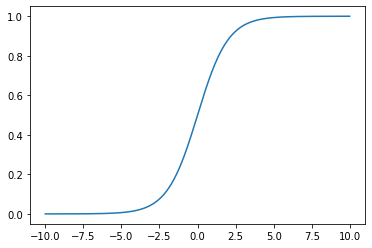

In [16]:
import matplotlib.pyplot as plt
import numpy as np

sigmoid_xs = np.arange(-10, 10, 0.01)
sigmoid_ys = 1 / (1 + np.exp(-sigmoid_xs))
plt.plot(sigmoid_xs, sigmoid_ys)

We can see the very small values essentially become 0, very large values essentially become 1 and everything in between is mapped to an appropriate probability value (with $\sigma(0) = 0.5$). This looks like a function that accomplishes what we intended.

Therefore we define our first neural network by *applying a sigmoid function to an affine function*. Yes, that's really all we are going to do! Note that while this is the simplest meaningful setup for a classification task, it is still a very *real* setup that is used in practice for certain tasks. 

Formally speaking, our network is defined as $y = f(x_1, x_2) = \sigma(x_1 \cdot w_1 + x_2 \cdot w_2 + b)$.

Let us represent this function using a computational graph.

First we split $f$ into its respective computations:

$h_1 = x_1 \cdot w_1$

$h_2 = x_2 \cdot w_2$

$h = h_1 + h_2$

$z = h + b$

$y = \sigma(z)$

Let's explicitly draw the graph:

<img src="images/simple_net.png" alt="drawing" width="600"/>

Note that this computational graph is indeed *differentiable* since every function has a derivative.

Recall that the basic idea behind the training of (any) machine learning model is quite simple. We start with randomly initialized parameters (we will discuss initialization schemes later). Then we iterate through all the examples and update the parameters in such a way that we improve our performance on those examples. We often do multiple iterations on the dataset. Each iteration is called an **epoch**. In its simplest form, the training loop therefore looks like this:

```python
model = NeuralNetwork()
for epoch in range(epochs):
    for x, t in dataset:
        model.update(x, t)
```

Note that in practice this is a bit different, but we will talk about this later.

The big question we will discuss in this chapter is how the update should be performed. Intuitively, we would like to update the model parameters in such a way that the network "performs" a bit better on the example $x$ labeled with the target value $t$.

## Updating our parameters

How could we accomplish that? First of all we need to define a **loss function** which is the measure of how far the output of the network is from the correct target. We then simply update our parameters in such a way that the *loss decreases*. Put differently, we want to *minimize the loss*.

In this particular case we will use a loss function called **binary crossentropy** which is defined as $BCE(y, t) = -t \cdot log(y) - (1 - t) \cdot log(1 - y)$. Here $y$ is the value produced by our network and $t$ is the target value.

Binary crossentropy is a concept deep learning shamelessly stole (a.k.a. *borrowed*) from information theory, but we will not go into all that and instead motivate it with very simple intuition. Basically if $t = 1$, then we want the loss to be proportional to $-\log(y)$. This is because a lower $y$ in our interpretation means a higher probability of $t = 0$ which is bad if in reality $t = 1$. Similarly, if $t = 0$, we want the loss to be proportional to $-\log(1 - y)$. Now we simply combine this into one expression which gets us the formula from above.

How does the loss fit into the computational graph? Even deep learning practicioners sometimes get confused about that, but the simple truth is that the loss is just another node put on top of the network:

<img src="images/simple_net_loss.png" alt="drawing" width="600"/>

Let us take our simple neural net and set $w_1 = w_2 = 0.5$, $b = 0$. A quick calculation yields an output value of $y = 0.6225$ for $x_1 = 0$, $x_2 = 1$. We see that the output value is not quite right. It should be $t = 0$ and not $y = 0.6225$. Therefore we want to update the parameters of the network (i.e. $w_1, w_2$ and $b$) in such a way that the output $y$ becomes a bit closer to the target $t$.

What this really means is that we have to update our weights in such a way that the loss (let us call it $L$) becomes smaller. How could we approach this?

If you have some basic knowledge of optimization theory, you are probably smirking right now. This is what gradient descent (and a bunch of other optimization algorithms) are for! However even if you do not know any numerical optimization, you can still easily develop an idea for what we should do.

Remember from high school that the derivative $\frac{\partial L}{\partial b}$ tells you the way $L$ changes if we change $b$. For example if $\frac{\partial L}{\partial b} > 0$ then increasing $b$ would lead to an increase in $L$. If $\frac{\partial L}{\partial b} < 0$ then an increase in $b$ would lead to a decrease in $L$.

Now assume that we somehow get our hands on $\frac{\partial L}{\partial b}$. We want to change $b$ in such a way that $L$ decreases. After all, we want to *minimize* the loss. Therefore we should update $b$ by a value proportionate to $-\frac{\partial L}{\partial b}$. Put differently, we want to update $b$ by $-\alpha \cdot \frac{\partial L}{\partial b}$ where $\alpha$ is some parameter that controls how big our update should be. Formally the update step therefore looks as follows:

$b^{(t+1)} = b^{(t)} - \alpha \cdot \frac{\partial L}{\partial b^{(t)}}$

That is, at step $t$ we update $b$ by subtracting $\alpha \cdot \frac{\partial L}{\partial b^{(t)}}$ from it.

A similar logic applies to the other parameters, i.e.

$w_1^{(t+1)} = w_1^{(t)} - \alpha \cdot \frac{\partial L}{\partial w_1^{(t)}}$

$w_2^{(t+1)} = w_2^{(t)} - \alpha \cdot \frac{\partial L}{\partial w_2^{(t)}}$

After such an update the loss would become smaller. But how could we could calculate the derivative $\frac{\partial L}{\partial b}$? Calculating e.g. the derivative $\frac{\partial L}{\partial y}$ would be easy - we would simply need to take the derivative of the loss function. But $b$ does not influence the loss directly, it influences the loss through $y$.

Despair not, we can use the *chain rule*. We know that $\frac{\partial L}{\partial b}$ can be calculated as $\frac{\partial L}{\partial b} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial b}$. But now we have the same problem. Again $b$ is not a direct input to $y$. How do we get $\frac{\partial y}{\partial b}$?

You can probably already see where this is going. We see that $y$ depends on $b$ through $z$. By the chain rule we have $\frac{\partial y}{\partial b} = \frac{\partial y}{\partial z} \frac{\partial z}{\partial b}$.

We therefore have: $\frac{\partial L}{\partial b} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z} \frac{\partial z}{\partial b}$. Now we only need to calculate the individual derivatives using our knowledge of basic differentiation and we are all set.

1. We begin with $\frac{\partial L}{\partial y}$. Since $L = -t \cdot log(y) - (1 - t) \cdot log(1 - y)$ we have $\frac{\partial L}{\partial y} = \frac{y - t}{(1 - y)y}$.

2. Similarly we get $\frac{\partial y}{\partial z} = \frac{\exp(-z)}{(1 + \exp(-z))^2}$.

3. Finally we have $\frac{\partial z}{\partial b} = 1$.

Therefore $\frac{\partial L}{\partial b} = \frac{y - t}{(1 - y)y} \cdot \frac{\exp(-z)}{(1 + \exp(-z))^2}$

The same logic holds for $w_1$ and $w_2$. Here we have $\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z} \frac{\partial z}{\partial h} \frac{\partial h}{\partial h_1} \frac{\partial h_1}{\partial w_1}$

Since $\frac{\partial L}{\partial y} = -\frac{t}{y} + \frac{1 - t}{1 - y}$, $\frac{\partial y}{\partial z} = \frac{\exp(-z)}{(1 + \exp(-z))^2}$, $\frac{\partial z}{\partial h} = 1$, $\frac{\partial h}{\partial h_1} = 1$ and $\frac{\partial h_1}{\partial w_1} = x_1$ we have $\frac{\partial L}{\partial w_1} = \frac{y - t}{(1 - y)y} \cdot \frac{\exp(-z)}{(1 + \exp(-z))^2} \cdot x_1$.

You *should* verify all of this. It's a nice and simple, but *very relevant* exercise in calculating derivatives.

In a very similar fashion $\frac{\partial L}{\partial w_2} = \frac{y - t}{(1 - y)y} \cdot \frac{\exp(-z)}{(1 + \exp(-z))^2} \cdot x_2$

Let's write all of this down in code:

In [17]:
class SimpleNet:
    def __init__(self):
        self.w1 = 0.5
        self.w2 = 0.5
        self.b = 0.0
        
        self.alpha = 1.0
        
    def forward(self, x1, x2, t):
        h1 = x1 * self.w1
        h2 = x2 * self.w2
        h = h1 + h2
        z = h + self.b
        y = 1 / (1 + exp(-z))
        L = -t * log(y) - (1 - t) * log(1 - y)
        return { "x1": x1, "x2": x2, "h1": h1, "h2": h2, "h": h, "z": z, "y": y, "L": L }
        
    def update(self, x1, x2, t):
        # Forward pass
        forward_res = self.forward(x1, x2, t)
        z, y = forward_res["z"], forward_res["y"]
        
        # Derivatives
        dLdy = (y - t) / ((1 - y) * y)
        dydz = exp(-z) / (1 + exp(-z)) ** 2
        dLdw1 = dLdy * dydz * x1
        dLdw2 = dLdy * dydz * x2
        dLdb = dLdy * dydz
        
        # Update
        self.w1 -= self.alpha * dLdw1
        self.w2 -= self.alpha * dLdw2
        self.b -= self.alpha * dLdb
        return { "dLdw1": dLdw1, "dLdw2": dLdw2, "dLdb": dLdb }

While this is pretty long, it's really just our above formulas written in Python.

Let's take the first example from the dataset:

In [18]:
x1, x2, t = 0.0, 0.0, 0.0

net = SimpleNet()

We run a forward pass:

In [19]:
net.forward(x1, x2, t)

{'x1': 0.0,
 'x2': 0.0,
 'h1': 0.0,
 'h2': 0.0,
 'h': 0.0,
 'z': 0.0,
 'y': 0.5,
 'L': 0.6931471805599453}

Now we execute an update:

In [20]:
net.update(x1, x2, t)

{'dLdw1': 0.0, 'dLdw2': 0.0, 'dLdb': 0.5}

We can see that $w_1$, $w_2$ and $b$ changed:

In [21]:
net.w1, net.w2, net.b

(0.5, 0.5, -0.5)

But did that change make sense? We could check this by running a forward pass and seeing if the loss decreased, i.e. if $y$ is closer to $t$ now:

In [22]:
net.forward(x1, x2, t)

{'x1': 0.0,
 'x2': 0.0,
 'h1': 0.0,
 'h2': 0.0,
 'h': 0.0,
 'z': -0.5,
 'y': 0.3775406687981454,
 'L': 0.47407698418010663}

This looks good! Now all we have to do is to repeatedly iterate over the dataset and do updates:

In [23]:
net = SimpleNet()
for epoch in range(100):
    for i in range(4):
        x1, x2, t = x1s[i], x2s[i], ts[i]
        net.update(x1, x2, t)

That's it! We successfully trained our first neural network. If you understood the preceding section, you've come a *tremendously long* way to understanding how neural networks operate. The rest of this chapter is really just about coming up with a more efficient algorithm for doing this (as calculating all the derivatives by hand is very tedious).

Before we move on, let us verify that we indeed get useful predictions:

In [24]:
for i in range(4):
    result = net.forward(x1s[i], x2s[i], ts[i])
    print(result)

{'x1': tensor(0.), 'x2': tensor(0.), 'h1': tensor(0.), 'h2': tensor(0.), 'h': tensor(0.), 'z': tensor(-8.9435), 'y': 0.00013056159878900093, 'L': tensor(0.0001)}
{'x1': tensor(0.), 'x2': tensor(1.), 'h1': tensor(0.), 'h2': tensor(5.8847), 'h': tensor(5.8847), 'z': tensor(-3.0589), 'y': 0.04483687464928194, 'L': tensor(0.0459)}
{'x1': tensor(1.), 'x2': tensor(0.), 'h1': tensor(5.9416), 'h2': tensor(0.), 'h': tensor(5.9416), 'z': tensor(-3.0019), 'y': 0.0473383390833865, 'L': tensor(0.0485)}
{'x1': tensor(1.), 'x2': tensor(1.), 'h1': tensor(5.9416), 'h2': tensor(5.8847), 'h': tensor(11.8263), 'z': tensor(2.8827), 'y': 0.9469867809360202, 'L': tensor(0.0545)}


Incredible! We can see that loss has become very small for every point. Let us have a look at the learned parameters and try to gain an intuition for what the network learned:

In [25]:
net.w1, net.w2, net.b

(tensor(5.9416), tensor(5.8847), tensor(-8.9435))

Basically we learned the function $y = f(x_1, x_2) = \sigma(5.94 \cdot x_1 + 5.88 \cdot x_2 - 8.94)$. This makes sense. Essentially the network said "$x_1$ and $x_2$ both need to make a contribution to produce a large value, otherwise the bias will pull the total value down", which is just another description for the *AND* function.

## Improving the parameter update with backpropagation

Manual updates work, but involve calculating lots of derivatives. This would mean that for every new model we would need to recalculate all the derivatives by hand. This is annoying. We want to be able to do this more effectively. 

We should more closely examine the flow of derivatives through the network:

<img src="images/backprop.png" alt="drawing" width="800"/>

As you can see the derivatives flow *backwards* (hence the name **backpropagation**). 

Let us look at a node up close. We take the sigmoid node. The derivative that flows out ($\frac{\partial L}{\partial z}$) only depends on the derivative that flows in ($\frac{\partial L}{\partial y}$) and the *local derivative* $\frac{\partial y}{\partial z}$. After all the chain rule tells us that $\frac{\partial L}{\partial z} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z}$.

The same holds true for all the other nodes! This is such an important point that I even put an *exclamation mark* behind it. *Given the derivative flowing in each node can calculate the derivative flowing out.* Instead of calculating the derivatives for every network from scratch, we specify a bunch of nodes. Every node has a *forward* function which takes some inputs and produces some outputs and a *backward* function which takes the derivative flowing in and produces the derivative flowing out. We can then execute approximately the following **backpropagation** algorithm :

```python
forward_sorted_nodes = sort_forward(nodes)
for node in forward_sorted_nodes:
    incoming_nodes = get_incoming_nodes(node)
    node.output_values = node.calc_output_values(incoming_nodes)
    
backward_sorted_nodes = sort_backward(nodes)
for node in backward_sorted_nodes:
    outgoing_node = get_outgoing_node(node)
    local_grad = node.get_local_grad()
    node.grad = local_grad * outgoing_node.grad
```

Let us now implement a bunch of nodes in pytorch. Note that we usually do not have to do that (the pytorch authors already implemented most of the important nodes). Nevertheless this is an extremely useful exercise that will teach you a great deal about how neural networks *really work*.

We begin by implementing the addition node. The forward function would simply be $z = x + y$. For the backward function we would need to return two gradients - one for $x$ and one for $y$. They are pretty simple. We see that $\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z}\frac{\partial z}{\partial x}$. Since $\frac{\partial z}{\partial x} = 1$ we have $\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z}$. Similarly $\frac{\partial L}{\partial y} = \frac{\partial L}{\partial z}$. Let us put this in code.

In [26]:
class Add(Function):
    @staticmethod
    def forward(ctx, x, y):
        return x + y

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, grad_output

Now we turn to multiplication. The forward function is $z = x \cdot y$. The backward pass again needs to calculate $\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z}\frac{\partial z}{\partial x}$. However now the local gradients are different. We have $\frac{\partial z}{\partial x} = y$ and $\frac{\partial z}{\partial y} = x$. This means that the backward pass is dependent on the forward pass. This is no problem however, as we can store the values from the forward pass using the ctx object:

In [27]:
class Mul(Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.x, ctx.y = x, y
        return x * y

    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.x, ctx.y
        return grad_output * y, grad_output * x

The sigmoid function is very similar:

In [28]:
class Sigmoid(Function):
    @staticmethod
    def forward(ctx, x):
        ctx.x = x
        return torch.tensor(1 / (1 + exp(-x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.x
        
        # Note that here we need to convert the local gradient to a tensor
        grad_local = torch.tensor(exp(-x) / (1 + exp(-x)) ** 2)
        return grad_output * grad_local

Finally this is how the node for the BCE loss would look like:

In [29]:
class BCELoss(Function):
    @staticmethod
    def forward(ctx, y, t):
        ctx.y, ctx.t = y, t          
        return -t * log(y) - (1 - t) * log(1 - y)

    @staticmethod
    def backward(ctx, grad_output):
        y, t = ctx.y, ctx.t
        y_grad_local = (y - t) / ((1 - y) * y)
        t_grad_local = -log(y) + log(1 - y)
        return grad_output * y_grad_local, grad_output * t_grad_local

Let us sanity check this. We pass the following values:

In [30]:
x1 = torch.tensor(0.0)
x2 = torch.tensor(0.0)
w1 = torch.tensor(0.5, requires_grad=True)
w2 = torch.tensor(0.5, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

Now we execute the forward pass:

In [31]:
h1 = Mul.apply(w1, x1)
h2 = Mul.apply(w2, x2)
h = Add.apply(h1, h2)
z = Add.apply(h, b)
y = Sigmoid.apply(z)
t = torch.tensor(0.0)
L = BCELoss.apply(y, t)
{ "h1": h1, "h2": h2, "h": h, "z": z, "y": y, "L": L }

{'h1': tensor(0., grad_fn=<MulBackward>),
 'h2': tensor(0., grad_fn=<MulBackward>),
 'h': tensor(0., grad_fn=<AddBackward>),
 'z': tensor(0., grad_fn=<AddBackward>),
 'y': tensor(0.5000, grad_fn=<SigmoidBackward>),
 'L': tensor(0.6931, grad_fn=<BCELossBackward>)}

Looks good so far. Now we call the backward function on the loss node. Pytorch will automatically calculate the gradients using the algorithm from above:

In [32]:
L.backward()

In [33]:
w1.grad, w2.grad, b.grad

(tensor(0.), tensor(0.), tensor(0.5000))

This is the same as the result we got in the manual version from above. Let us define the forward and update functions, but now using our nodes instead of manual derivative calculations:

In [34]:
class AutoSimpleNet:
    def __init__(self):
        self.w1 = torch.tensor(0.5, requires_grad=True)
        self.w2 = torch.tensor(0.5, requires_grad=True)
        self.b = torch.tensor(0.0, requires_grad=True)
        
        self.alpha = 1.0
        
    def forward(self, x1, x2, t):
        h1 = Mul.apply(self.w1, x1)
        h2 = Mul.apply(self.w2, x2)
        h = Add.apply(h1, h2)
        z = Add.apply(h, self.b)
        y = Sigmoid.apply(z)
        L = BCELoss.apply(y, t)
        return { "x1": x1, "x2": x2, "h1": h1, "h2": h2, "h": h, "z": z, "y": y, "L": L }
        
    def update(self, x1, x2, t):
        # Forward pass
        forward_res = self.forward(x1, x2, t)
        L = forward_res["L"]
        
        # Backward pass
        L.backward()
        
        # Update
        with torch.no_grad():
            dLdw1 = float(self.w1.grad)
            dLdw2 = float(self.w2.grad)
            dLdb = float(self.b.grad)
            self.w1 -= self.alpha * dLdw1
            self.w2 -= self.alpha * dLdw2
            self.b -= self.alpha * dLdb
            
            self.w1.grad.zero_()
            self.w2.grad.zero_()
            self.b.grad.zero_()
        return forward_res, { "dLdw1": dLdw1, "dLdw2": dLdw2, "dLdb": dLdb }

The training loop doesn't change:

In [35]:
net = AutoSimpleNet()
for epoch in range(100):
    for i in range(4):
        x1, x2, t = x1s[i], x2s[i], ts[i]
        net.update(x1, x2, t)

And now for the moment of truth. 

In [36]:
for i in range(4):
    result = net.forward(x1s[i], x2s[i], ts[i])
    print(result)

{'x1': tensor(0.), 'x2': tensor(0.), 'h1': tensor(0., grad_fn=<MulBackward>), 'h2': tensor(0., grad_fn=<MulBackward>), 'h': tensor(0., grad_fn=<AddBackward>), 'z': tensor(-8.9435, grad_fn=<AddBackward>), 'y': tensor(0.0001, grad_fn=<SigmoidBackward>), 'L': tensor(0.0001, grad_fn=<BCELossBackward>)}
{'x1': tensor(0.), 'x2': tensor(1.), 'h1': tensor(0., grad_fn=<MulBackward>), 'h2': tensor(5.8847, grad_fn=<MulBackward>), 'h': tensor(5.8847, grad_fn=<AddBackward>), 'z': tensor(-3.0589, grad_fn=<AddBackward>), 'y': tensor(0.0448, grad_fn=<SigmoidBackward>), 'L': tensor(0.0459, grad_fn=<BCELossBackward>)}
{'x1': tensor(1.), 'x2': tensor(0.), 'h1': tensor(5.9416, grad_fn=<MulBackward>), 'h2': tensor(0., grad_fn=<MulBackward>), 'h': tensor(5.9416, grad_fn=<AddBackward>), 'z': tensor(-3.0019, grad_fn=<AddBackward>), 'y': tensor(0.0473, grad_fn=<SigmoidBackward>), 'L': tensor(0.0485, grad_fn=<BCELossBackward>)}
{'x1': tensor(1.), 'x2': tensor(1.), 'h1': tensor(5.9416, grad_fn=<MulBackward>), 'h

That looks great! Let us perform an additional sanity check by confirming that $w_1$, $w_2$ and $b$ have the same values as in the manual version:

In [37]:
net.w1, net.w2, net.b

(tensor(5.9416, requires_grad=True),
 tensor(5.8847, requires_grad=True),
 tensor(-8.9435, requires_grad=True))

Incredibly enough, there is not much more than this to backpropagation. We will now discuss a bunch of (important) technical details, but you can already go and impress everyone with your newfound knowledge! Go ahead and do just that - you now understand the algorithm which underpins basically all of deep learning - from the simplest perceptrons to the fanciest state of the art models out there.

## Backpropagation in pytorch

Of course in reality we do not actually go around implementing all the backward functions from scratch. The pytorch team has already done that for *a lot* of functions. We can therefore simply declare the computational graph using those builtin functions, call `backward` and then do the gradient updates:

In [38]:
class TorchSimpleNet:
    def __init__(self):
        self.w1 = torch.tensor(0.5, requires_grad=True)
        self.w2 = torch.tensor(0.5, requires_grad=True)
        self.b = torch.tensor(0.0, requires_grad=True)
        
        self.alpha = 1.0
        
        self.loss_fun = nn.BCELoss()
        
    def forward(self, x1, x2, t):
        h1 = torch.mul(self.w1, x1)
        h2 = torch.mul(self.w2, x2)
        h = torch.add(h1, h2)
        z = torch.add(h, self.b)
        y = torch.sigmoid(z)
        z.retain_grad()
        y.retain_grad()
        
        L = self.loss_fun(y, t.float())
        return { "x1": x1, "x2": x2, "h1": h1, "h2": h2, "h": h, "z": z, "y": y, "t": t, "L": L }

    def update(self, x1, x2, t):
        forward_res = self.forward(x1, x2, t)
        L = forward_res["L"]
        
        # Backward
        L.backward()
        
        # Update
        with torch.no_grad():
            dLdw1 = float(self.w1.grad)
            dLdw2 = float(self.w2.grad)
            dLdb = float(self.b.grad)
            self.w1 -= self.alpha * dLdw1
            self.w2 -= self.alpha * dLdw2
            self.b -= self.alpha * dLdb
            
            self.w1.grad.zero_()
            self.w2.grad.zero_()
            self.b.grad.zero_()
        
        return forward_res, { "dLdw1": dLdw1, "dLdw2": dLdw2, "dLdb": dLdb }

Again the training loop doesn't change at all:

In [39]:
net = TorchSimpleNet()
for epoch in range(100):
    for i in range(4):
        x1, x2, t = x1s[i], x2s[i], ts[i]
        net.update(x1, x2, t) 

We do the forward passes:

In [40]:
for i in range(4):
    x1, x2, t = x1s[i], x2s[i], ts[i]
    print(net.forward(x1, x2, t))

{'x1': tensor(0.), 'x2': tensor(0.), 'h1': tensor(0., grad_fn=<MulBackward0>), 'h2': tensor(0., grad_fn=<MulBackward0>), 'h': tensor(0., grad_fn=<AddBackward0>), 'z': tensor(-8.9435, grad_fn=<AddBackward0>), 'y': tensor(0.0001, grad_fn=<SigmoidBackward0>), 't': tensor(0), 'L': tensor(0.0001, grad_fn=<BinaryCrossEntropyBackward0>)}
{'x1': tensor(0.), 'x2': tensor(1.), 'h1': tensor(0., grad_fn=<MulBackward0>), 'h2': tensor(5.8847, grad_fn=<MulBackward0>), 'h': tensor(5.8847, grad_fn=<AddBackward0>), 'z': tensor(-3.0589, grad_fn=<AddBackward0>), 'y': tensor(0.0448, grad_fn=<SigmoidBackward0>), 't': tensor(0), 'L': tensor(0.0459, grad_fn=<BinaryCrossEntropyBackward0>)}
{'x1': tensor(1.), 'x2': tensor(0.), 'h1': tensor(5.9416, grad_fn=<MulBackward0>), 'h2': tensor(0., grad_fn=<MulBackward0>), 'h': tensor(5.9416, grad_fn=<AddBackward0>), 'z': tensor(-3.0019, grad_fn=<AddBackward0>), 'y': tensor(0.0473, grad_fn=<SigmoidBackward0>), 't': tensor(0), 'L': tensor(0.0485, grad_fn=<BinaryCrossEntro

Let us also sanity check the gradients:

In [41]:
net.w1, net.w2, net.b

(tensor(5.9416, requires_grad=True),
 tensor(5.8847, requires_grad=True),
 tensor(-8.9435, requires_grad=True))

This is a very basic and simple, but *complete* example of a neural network. We can however tweak a bunch of things.

First the **architecture** of our network will usually be more complex.

Second for different cases we need to use different **loss functions**.

Third the update step will often be different as defined by an **optimizer**.

Fourth the initilization will be different as defined by an **initialization scheme**.

We will tackle these things in the next chapter.